In [1]:
import gammapy 
print(f'loaded gammapy version: {gammapy.__version__} ' )
print(f'Supposed to be 1.0 (21-12-2022)' )

loaded gammapy version: 1.1.dev320+g92a6eb9f4 
Supposed to be 1.0 (21-12-2022)


In [2]:
#get_ipython().system('jupyter nbconvert --to script 1-Nui_Par_Fitting.ipynb')
import pyximport

pyximport.install()
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import gammapy

# from gammapy.datasets import MapDataset
from gammapy.maps import Map
from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit, Parameter, Parameters, Covariance
from gammapy.datasets import MapDataset #, MapDatasetNuisance
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    create_crab_spectral_model,
    SkyModel,
    PointSpatialModel,
    ShellSpatialModel,
    GeneralizedGaussianSpatialModel,
    TemplateSpatialModel,
    LogParabolaSpectralModel,
    GaussianSpatialModel,
    DiskSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
)
from gammapy.estimators import TSMapEstimator, ExcessMapEstimator

from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys

#sys.path.append(
#    "/home/hpc/caph/mppi045h/3D_analysis/N_parameters_in_L/syserror_3d_bkgmodel/4-Fitting_nuisance_and_model_parameters"
#)
#from my_dataset_maps_20 import MapDatasetNuisance
#from MapDatasetNuisanceE import MapDatasetNuisanceE
#from  my_fit_20 import Fit
from Dataset_Creation import sys_dataset

## Read dataset

spatial binsize =  [0.08] deg
MapDataset
----------

  Name                            : lRQFWcpg 

  Total counts                    : 388209 
  Total background counts         : 360331.31
  Total excess counts             : 27877.69

  Predicted counts                : 361333.07
  Predicted background counts     : 360331.34
  Predicted excess counts         : 1001.73

  Exposure min                    : 2.07e-01 m2 s
  Exposure max                    : 2.41e+11 m2 s

  Number of total bins            : 540000 
  Number of fit bins              : 180191 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : -924522.99

  Number of models                : 2 
  Number of parameters            : 11
  Number of free parameters       : 7

  Component 0: SkyModel
  
    Name                      : Source
    Datasets names            : None
    Spectral model type       : PowerLawSpectralModel
    Spatial  model type       : GaussianSpatialModel
    Temporal model ty

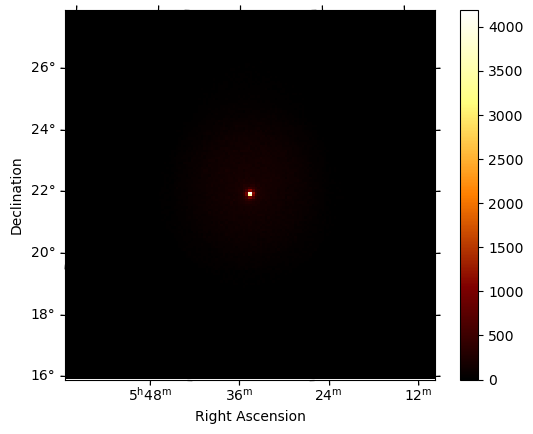

In [3]:
source = 'Crab'
path = '/home/vault/caph/mppi062h/repositories/HESS_3Dbkg_syserror/2-error_in_dataset'
path_crab = '/home/hpc/caph/mppi045h/3D_analysis/N_parameters_in_L/nuisance_summary/Crab'


dataset_standard = MapDataset.read(f'{path}/{source}/stacked.fits')
dataset_standard = dataset_standard.downsample(4)
models = Models.read(f"{path_crab}/standard_model.yml")
model_spectrum  = PowerLawSpectralModel(
    index=2.3,
    amplitude="1e-12 TeV-1 cm-2 s-1",    )
source_model = SkyModel(spatial_model = models['main source'].spatial_model ,
                       spectral_model = model_spectrum,
                       name = "Source")    
models = Models(source_model)

bkg_model = FoVBackgroundModel(dataset_name=dataset_standard.name)
bkg_model.parameters['tilt'].frozen  = False
models.append(bkg_model)
dataset_standard.models = models

dataset_asimov = dataset_standard.copy()
dataset_asimov.counts = dataset_standard.npred()
models = Models(source_model.copy())
bkg_model = FoVBackgroundModel(dataset_name=dataset_asimov.name)
bkg_model.parameters['tilt'].frozen  = False
models.append(bkg_model)
dataset_asimov.models = models

    
dataset_standard.counts.sum_over_axes().plot(add_cbar=1)
binsize = dataset_standard.geoms["geom"].width[1] / dataset_standard.geoms["geom"].data_shape[1]
print(
    "spatial binsize = ",
    binsize
)

print(dataset_standard)

## Varying the Exposure

In [8]:
savefig = False
picformat = 'svg'

shift = 0.1
delta_shift = 0.08
n = 24
tilt = +delta_shift/n 
print(tilt)


0.0033333333333333335


In [9]:
infos = np.loadtxt("data/7a_P_draw_info.txt")
pars = np.loadtxt("data/7a_P_draw_par.txt")
flux = np.loadtxt("data/7a_P_draw_flux.txt")
flux2e = np.loadtxt("data/7a_P_draw_flux2e.txt")


lem = len(infos)
N_max = 1000
N = np.min([lem, N_max])

print(N)

shift_rnds = infos[:N_max,0]
index_rnds = infos[:N_max,1]
stat_sums = infos[:N_max,2]


#amplitude', 'index', 'norm', 'tilt
amplitudes = pars[:N_max,0:2] 
indices = pars[:N_max,2:4] 
norms = pars[:N_max,4:6]
tilts = pars[:N_max,6:8]



765


In [6]:


sys_ = sys_dataset(dataset_asimov= dataset_asimov,
                        shift = 0, 
                        tilt = 0,
                        rnd = False)
dataset_asimov = sys_.create_dataset()
dataset_asimov_N = sys_.create_dataset_N()
sigma_a = shift
sigma_i = tilt 
zero = 1e-24
penalising_covmatrix = [[1/sigma_i**2, zero], [zero , 1/sigma_a**2]]
penalising_invcovmatrix =  penalising_covmatrix
dataset_asimov_N.penalising_invcovmatrix = penalising_invcovmatrix


5
5


In [7]:
fit_cor = Fit(store_trace=False)
result_cor = fit_cor.run([dataset_asimov])    
result_cor = fit_cor.run([dataset_asimov_N]) 
dataset_asimov_N.models[0].parameters['amplitude_nuisance'].frozen = True
dataset_asimov_N.models[0].parameters['index_nuisance'].frozen = True

In [8]:
dataset_asimov.models[0].spectral_model.parameters.to_table()

type,name,value,unit,error,min,max,frozen,is_norm,is_penalised,link
str8,str9,float64,str14,float64,float64,float64,bool,bool,bool,str1
spectral,index,2.3000e+00,,6.172e-02,nan,nan,False,False,False,
spectral,amplitude,1.0000e-12,cm-2 s-1 TeV-1,8.982e-14,nan,nan,False,True,False,
spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,False,False,


In [9]:
dataset_asimov_N.models[0].spectral_model.parameters.to_table()

type,name,value,unit,error,min,max,frozen,is_norm,is_penalised,link
str8,str18,float64,str14,float64,float64,float64,bool,bool,bool,str1
spectral,index,2.3000e+00,,6.217e-02,nan,nan,False,False,False,
spectral,index_nuisance,0.0000e+00,,3.328e-03,nan,nan,True,False,True,
spectral,amplitude,1.0000e-12,cm-2 s-1 TeV-1,1.462e-13,nan,nan,False,True,False,
spectral,amplitude_nuisance,0.0000e+00,,1.087e-01,nan,nan,True,False,True,
spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,False,False,


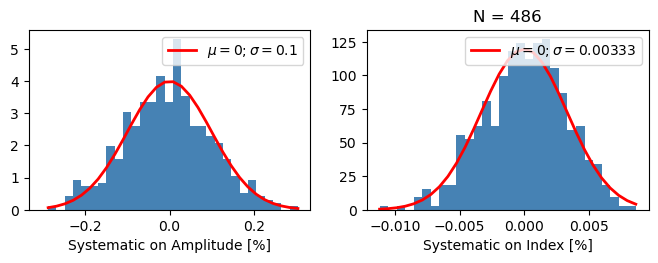

In [10]:
fig, (axs, ax1) = plt.subplots(1,2, figsize = (2*4,7/3))
nbins = 30
count, bins, ignored = axs.hist(shift_rnds, nbins, density=True, color = 'steelblue')
sigma =shift
mu = 0
axs.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) *
               np.exp( - (bins - mu)**2 / (2 * sigma**2) ),
         linewidth=2, color='r', label = f'$\mu = {mu}; \sigma = {sigma}$')

axs.set_xlabel("Systematic on Amplitude [%]")
axs.legend()

x = axs.get_xlim()
deltax = np.max([ mu - x[0] , x[1] - mu ])
axs.set_xlim(mu -deltax, 
                mu + deltax)


count, bins, ignored = ax1.hist(index_rnds, nbins, density=True, color = 'steelblue')
sigma =tilt
mu = 0
ax1.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) *
               np.exp( - (bins - mu)**2 / (2 * sigma**2) ),
         linewidth=2, color='r', label = f'$\mu = {mu}; \sigma = {sigma:.3}$')

ax1.set_xlabel("Systematic on Index [%]")
ax1.set_title(f"N = {N}")
ax1.legend()

x = axs.get_xlim()
deltax = np.max([ mu - x[0] , x[1] - mu ])
axs.set_xlim(mu -deltax, 
                mu + deltax)

if savefig:
    fig.savefig(f"plots/7b_rnd_sys_{shift}_{N}." + picformat)   
    


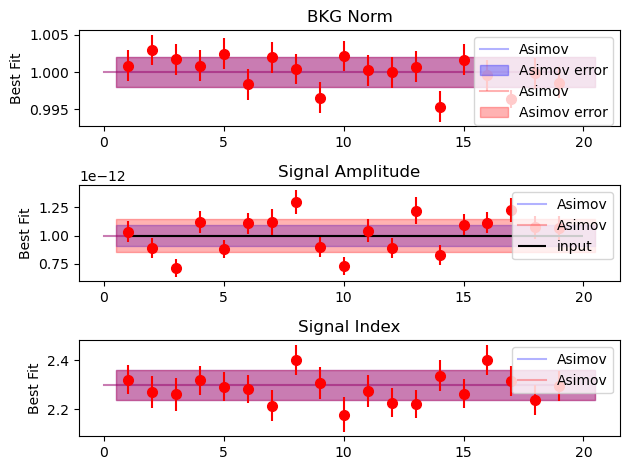

In [11]:
fig, axs = plt.subplots(3,1)

axs[0].set_title("BKG Norm")
axs[1].set_title("Signal Amplitude")
axs[2].set_title("Signal Index")

N_plot = 20
labels = [ '-10%', '0%', '10%']

colors = ['blue', 'red']
for i, d in enumerate([dataset_asimov, dataset_asimov_N]):
    
    best = d.models[1].parameters['norm'].value
    er = d.models[1].parameters['norm'].error
    axs[0].plot( [best] * N_plot, color  = colors[i], alpha = 0.3, label = "Asimov")
    axs[0].fill_betweenx( [best-er , best + er], 0.5, N_plot+0.5, color  = colors[i], alpha = 0.3,
                        label = "Asimov error")
    
    best = d.models[0].parameters['amplitude'].value
    er = d.models[0].parameters['amplitude'].error
    axs[1].fill_betweenx( [best-er , best + er], 0.5, N_plot+0.5, color  = colors[i], alpha = 0.3)
    axs[1].plot( [best] * N_plot, color  = colors[i], alpha = 0.3, label = "Asimov")

    best = d.models[0].parameters['index'].value
    er = d.models[0].parameters['index'].error
    axs[2].fill_betweenx( [best-er , best + er], 0.5, N_plot+0.5, color  = colors[i], alpha = 0.3)
    axs[2].plot( [best] * N_plot, color  = colors[i], alpha = 0.3, label = "Asimov")

for i, a in enumerate(norms[1:N_plot]):
    axs[0].errorbar(x= i+1, y = a[0], yerr = a[1], fmt= 'o', color =  'red',markersize=7)
#axs[0].hlines( norms[0][0], 1, N, label = "input", color = 'black')


for i, a in enumerate(amplitudes[1:N_plot]):
    axs[1].errorbar(x= i+1, y = a[0], yerr = a[1], fmt= 'o', color =  'red',markersize=7)
axs[1].hlines( 1e-12, 1, N_plot, label = "input", color ='black')


for i, a in enumerate(indices[1:N_plot]):
    axs[2].errorbar(x= i+1, y = a[0], yerr = a[1], fmt= 'o', color =  'red',markersize=7)
#axs[2].hlines( indices[0][0], 1, N, label = "input", color ='black')



plt.tight_layout()
for a in axs:
    a.legend(); 
    a.set_ylabel('Best Fit'); 

plt.tight_layout()    
#if savefig:
#    fig.savefig(f"plots/7b_best_fit_{factor}_{N}.pdf")   


In [12]:

valuies = [norms, amplitudes, indices]

valuies_asimov = [[dataset_asimov.models[1].parameters['norm'].value, 
                   dataset_asimov.models[1].parameters['norm'].error],
                  [dataset_asimov.models[0].parameters['amplitude'].value, 
                   dataset_asimov.models[0].parameters['amplitude'].error],
                  [dataset_asimov.models[0].parameters['index'].value, 
                   dataset_asimov.models[0].parameters['index'].error],]


valuies_asimov_N = [[dataset_asimov_N.models[1].parameters['norm'].value, 
                   dataset_asimov_N.models[1].parameters['norm'].error],
                  [dataset_asimov_N.models[0].parameters['amplitude'].value, 
                   dataset_asimov_N.models[0].parameters['amplitude'].error],
                  [dataset_asimov_N.models[0].parameters['index'].value, 
                   dataset_asimov_N.models[0].parameters['index'].error],]
is_within_norm = []
is_within_amplitude = []
is_within_index = []
is_within_norm_N = []
is_within_amplitude_N = []
is_within_index_N = []

i = 0
for n in norms:
    larger = np.all(n[0] >= (valuies_asimov[0][0] - valuies_asimov[0][1]))
    smaller = np.all(n[0] <= (valuies_asimov[0][0] + valuies_asimov[0][1]))
    is_within_norm.append(larger and smaller)
    
    larger = np.all(n[0] >= (valuies_asimov_N[0][0] - valuies_asimov_N[0][1]))
    smaller = np.all(n[0] <= (valuies_asimov_N[0][0] + valuies_asimov_N[0][1]))
    is_within_norm_N.append(larger and smaller)
    
for a in amplitudes:
    larger = np.all(a[0] >= (valuies_asimov[1][0] - valuies_asimov[1][1]))
    smaller = np.all(a[0] <= (valuies_asimov[1][0] + valuies_asimov[1][1]))
    is_within_amplitude.append(larger and smaller)
    
    larger = np.all(a[0] >= (valuies_asimov_N[1][0] - valuies_asimov_N[1][1]))
    smaller = np.all(a[0] <= (valuies_asimov_N[1][0] + valuies_asimov_N[1][1]))
    is_within_amplitude_N.append(larger and smaller)
    
for i in indices:
    larger = np.all(i[0] >= (valuies_asimov[2][0] - valuies_asimov[2][1]))
    smaller = np.all(i[0] <= (valuies_asimov[2][0] + valuies_asimov[2][1]))
    is_within_index.append(larger and smaller)
    
    larger = np.all(i[0] >= (valuies_asimov_N[2][0] - valuies_asimov_N[2][1]))
    smaller = np.all(i[0] <= (valuies_asimov_N[2][0] + valuies_asimov_N[2][1]))
    is_within_index_N.append(larger and smaller)
    
within_norm = [np.count_nonzero(is_within_norm)/N,
              np.count_nonzero(is_within_norm_N)/N]

within_amplitude = [np.count_nonzero(is_within_amplitude)/N,
              np.count_nonzero(is_within_amplitude_N)/N]

within_index = [np.count_nonzero(is_within_index)/N,
              np.count_nonzero(is_within_index_N )/N]

withins = [within_norm, 
          within_amplitude,
          within_index]

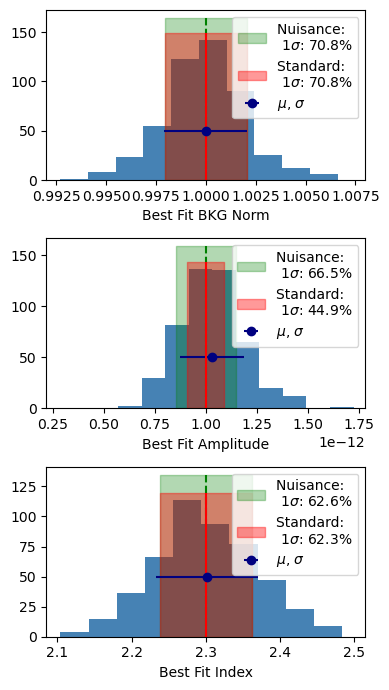

In [13]:
fig, axs = plt.subplots(3,1, figsize = (4,7))
xlabels = ["Best Fit BKG Norm", "Best Fit Amplitude", "Best Fit Index"]

axs[2].errorbar(x = np.mean(indices[:,0]) ,y = 50, xerr = np.std(indices[:,0]), fmt='o', 
                color = 'navy', label = "$\mu$, $\sigma$")
axs[1].errorbar(x = np.mean(amplitudes[:,0]) ,y = 50, xerr = np.std(amplitudes[:,0]), fmt='o',
               color = 'navy', label = "$\mu$, $\sigma$")
axs[0].errorbar(x = np.mean(norms[:,0]) ,y = 50, xerr = np.std(norms[:,0]), fmt='o',
               color = 'navy', label = "$\mu$, $\sigma$")
    

for i, v in enumerate(valuies):
    axs[i].hist(v[1:,0], color ='steelblue')
    ylim = axs[i].get_ylim()
    delta_ylim = 15
    
    axs[i].vlines(valuies_asimov_N[i][0], ylim[0], ylim[1]+ delta_ylim, color = 'green', 
                 linestyle= 'dashed', )
    axs[i].fill_between([valuies_asimov_N[i][0] - valuies_asimov_N[i][1],
                         valuies_asimov_N[i][0] + valuies_asimov_N[i][1]]
                        , ylim[0], ylim[1]+ delta_ylim,
                       alpha = 0.3, color = 'green', 
                        label = f'Nuisance: \n 1$\sigma$: {withins[i][1]*100 :.3}%')
    axs[i].vlines(valuies_asimov[i][0], ylim[0], ylim[1], color = 'red')
    axs[i].fill_between([valuies_asimov[i][0] - valuies_asimov[i][1],
                         valuies_asimov[i][0] + valuies_asimov[i][1]]
                        , ylim[0], ylim[1],
                       alpha = 0.4 , color = 'red', 
                        label = f'Standard: \n 1$\sigma$: {withins[i][0]*100 :.3}%'  )
    
    axs[i].legend(loc = 'upper right')  
    axs[i].set_xlabel(xlabels[i])  
    
    
    x = axs[i].get_xlim()
    deltax = np.max([ valuies_asimov[i][0] - x[0] , x[1] - valuies_asimov[i][0] ])
    axs[i].set_xlim(valuies_asimov[i][0] -deltax, 
                    valuies_asimov[i][0] + deltax)
    

plt.tight_layout()

if savefig:
    fig.savefig(f"plots/7b_histo_{shift}_{N}."+ picformat)

In [14]:
mask = dataset_asimov.mask.data[:,60,60]
ebins = dataset_asimov.counts.geom.axes[0].center[mask]
asimov, asimov_errors = dataset_asimov.models[0].spectral_model.evaluate_error(ebins)
asimov_N, asimov_errors_N = dataset_asimov_N.models[0].spectral_model.evaluate_error(ebins)


index
amplitude
index
amplitude


In [15]:
withine = []
withine_N = []

for ie, e in enumerate(ebins):
    xs = []
    xs_N = []
    for f in flux:
        value = f[ie]   
        lowerlim = (np.all(value <= asimov.value[ie] + asimov_errors.value[ie]))
        upperlim = (np.all(value >= asimov.value[ie] - asimov_errors.value[ie]))
        x = lowerlim & upperlim
        xs.append(x)
        
        lowerlim = (np.all(value <= asimov_N.value[ie] + asimov_errors_N.value[ie]))
        upperlim = (np.all(value >= asimov_N.value[ie] - asimov_errors_N.value[ie]))
        x = lowerlim & upperlim
        xs_N.append(x)
        
        
    withine.append(np.count_nonzero(xs) / N)
    withine_N.append(np.count_nonzero(xs_N) / N)


In [16]:
mean = flux2e.mean(axis = 0)
std = flux2e.std(axis = 0)

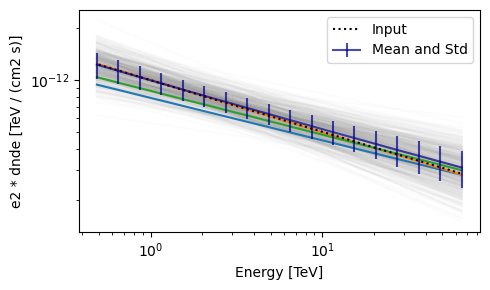

In [17]:
true_energy = dataset_asimov.exposure.geom.axes[0].center.value
energy_bounds = (ebins[0] , ebins[-1] ) *u.TeV
fig, axs = plt.subplots(1,1,figsize = (5,3) )
for i, f in enumerate(flux2e):
    axs.plot(ebins, f, color = 'grey', alpha = 10/N)
for i, f in enumerate(flux2e[:3]):
    axs.plot(ebins, f,)
axs.errorbar(ebins, mean, yerr = std,  color = 'darkblue', alpha = 0.7,
            label = "Mean and Std")

dataset_standard.models[0].spectral_model.plot(energy_bounds, linestyle=':', energy_power = 2, ax = axs,
                                label = "Input", color = "black", )
axs.legend()
axs.set_xlabel("Energy [TeV]")
plt.tight_layout()
if savefig:
    fig.savefig(f"plots/7b_rnd_spectra_{shift}_{N}." + picformat)

In [18]:
def compute_precision(N):
    Z = 1.645
    return  Z / np.sqrt(N)

index
amplitude
index
amplitude
index
amplitude
index
amplitude


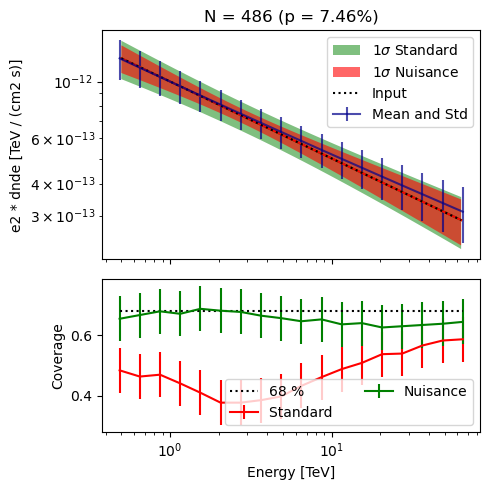

In [19]:
true_energy = dataset_asimov.exposure.geom.axes[0].center.value
energy_bounds = (ebins[0] , ebins[-1] ) *u.TeV
fig, (axs, ax2) = plt.subplots(2,1, gridspec_kw={'height_ratios': [3, 2]},
                         sharex = True, figsize = ((5,5)))
axs.errorbar(ebins, mean, yerr = std,  color = 'darkblue', alpha = 0.7,
            label = "Mean and Std")
dataset_asimov_N.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = axs,
                                label = "", color = "green")    

dataset_asimov_N.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs,
                                label = "$1\sigma$ Standard", facecolor = "green", alpha = 0.5)    
    
dataset_asimov.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = axs,
                                label = "", color = "red")    

dataset_asimov.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs,
                                label = "$1\sigma$ Nuisance", facecolor = "red", alpha = 0.6)

dataset_standard.models[0].spectral_model.plot(energy_bounds, linestyle=':', energy_power = 2, ax = axs,
                                label = "Input", color = "black", )
p = compute_precision(N)
ax2.errorbar(ebins, withine, yerr = p,  color = 'red', label = f"Standard ")
ax2.errorbar(ebins, withine_N, yerr = p , color = 'green', label = "Nuisance")
ax2.plot(ebins, [0.68] * len(ebins), ':', color = 'black', label = "68 %")

axs.set_xlabel('')
axs.legend()
ax2.legend(ncol = 2)
axs.set_title(f"N = {N} (p = {p*100:.3}%)")
ax2.set_xlabel('Energy [TeV]')
ax2.set_ylabel('Coverage')

plt.tight_layout()
if savefig:
    fig.savefig(f"plots/7b_spectra_{shift}_{N}." + picformat)


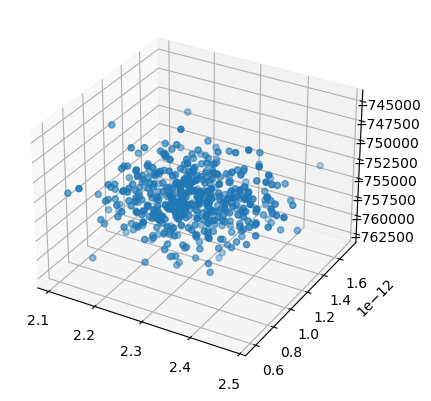

In [20]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(indices[:,0], amplitudes[:,0], stat_sums, marker='o')
    
